In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install and Import Packages**

In [ ]:

!pip install pandas numpy nltk tensorflow matplotlib rouge-score

import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import time
import math
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize

tf.config.run_functions_eagerly(True)
print("Eager execution enabled:", tf.executing_eagerly())

nltk.download('punkt')
nltk.download('wordnet')

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f42df58f811c2a8120ec245fc8397aeeb6d8f0b67b7f7ab6fefaa91c20378b72
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge-score
Eager execution enabled: True


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Data Preparation**

In [ ]:

df = pd.read_csv('/content/drive/MyDrive/DL_Dataset/questions.csv').dropna().head(10000)
print(f"Dataset size: {len(df)} rows")
questions1 = df['question1'].astype(str).tolist()
questions2 = df['question2'].astype(str).tolist()

questions2_with_tokens = ['<start> ' + q + ' <end>' for q in questions2]

tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(questions1 + questions2_with_tokens)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary size: {vocab_size}")

start_token_idx = tokenizer.word_index.get('<start>', 0)
end_token_idx = tokenizer.word_index.get('<end>', 0)
print(f"<start> token index: {start_token_idx}")
print(f"<end> token index: {end_token_idx}")

index_word = {v: k for k, v in tokenizer.word_index.items()}

max_len = 30

encoder_input = pad_sequences(tokenizer.texts_to_sequences(questions1), maxlen=max_len, padding='post')
decoder_input_raw = []
decoder_target_raw = []
for q in questions2_with_tokens:
    words = q.split()
    decoder_input_raw.append(' '.join(words[:-1]))
    decoder_target_raw.append(' '.join(words[1:]))
decoder_input = pad_sequences(tokenizer.texts_to_sequences(decoder_input_raw), maxlen=max_len, padding='post')
decoder_target = pad_sequences(tokenizer.texts_to_sequences(decoder_target_raw), maxlen=max_len, padding='post')

print("Encoder input shape:", encoder_input.shape)
print("Decoder input shape:", decoder_input.shape)
print("Decoder target shape:", decoder_target.shape)

Dataset size: 10000 rows
Vocabulary size: 15582
<start> token index: 0
<end> token index: 0
Encoder input shape: (10000, 30)
Decoder input shape: (10000, 30)
Decoder target shape: (10000, 30)


# **Transformer Model**

In [ ]:

def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def scaled_dot_product_attention(q, k, v, mask=None):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask=mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
    def call(self, x, training=True, mask=None):
        attn_output, _ = self.mha(x, x, x, mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        return out2

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    def call(self, x, enc_output, training=True, look_ahead_mask=None, padding_mask=None):
        attn1, _ = self.mha1(x, x, x, mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, _ = self.mha2(enc_output, enc_output, out1, mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)
        return out3

class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    def call(self, x, training=True, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)
        return x

class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, num_layers, d_model, num_heads, dff, maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
    def call(self, x, enc_output, training=True, look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](
                x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
        return x

class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, num_layers, d_model, num_heads, dff, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(vocab_size, num_layers, d_model, num_heads, dff, pe_input, rate)
        self.decoder = Decoder(vocab_size, num_layers, d_model, num_heads, dff, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(vocab_size)
    def call(self, inputs, training=True):
        encoder_input, decoder_input = inputs
        enc_padding_mask = self.create_padding_mask(encoder_input)
        dec_padding_mask = self.create_padding_mask(encoder_input)
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(decoder_input)[1])
        dec_target_padding_mask = self.create_padding_mask(decoder_input)
        combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
        enc_output = self.encoder(encoder_input, training=training, mask=enc_padding_mask)
        dec_output = self.decoder(
            decoder_input, enc_output, training=training, look_ahead_mask=combined_mask, padding_mask=dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output
    def create_padding_mask(self, seq):
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]
    def create_look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask

# Hyperparameters
num_layers = 2
d_model = 64
num_heads = 4
dff = 256
dropout_rate = 0.1

transformer = Transformer(
    vocab_size=vocab_size,
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    pe_input=max_len,
    pe_target=max_len,
    rate=dropout_rate
)

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=2000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
    loss = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

@tf.function
def train_step(enc_input, dec_input, dec_target):
    with tf.GradientTape() as tape:
        predictions = transformer([enc_input, dec_input], training=True)
        loss = loss_function(dec_target, predictions)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(dec_target, predictions)

# **Training**

In [ ]:

BATCH_SIZE = 32
BUFFER_SIZE = 10000
train_dataset = tf.data.Dataset.from_tensor_slices((encoder_input, decoder_input, decoder_target)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
EPOCHS = 5

print("Starting training...")
start_train = time.time()
loss_history = []
accuracy_history = []

for epoch in range(EPOCHS):
    start = time.time()
    try:
        train_loss.reset_states()
        train_accuracy.reset_states()
    except AttributeError:
        train_loss.reset_state()
        train_accuracy.reset_state()
    for (batch, (enc_input, dec_input, dec_target)) in enumerate(train_dataset):
        train_step(enc_input, dec_input, dec_target)
    loss_history.append(train_loss.result().numpy())
    accuracy_history.append(train_accuracy.result().numpy())
    print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

end_train = time.time()
print(f"Training Time: {end_train - start_train:.2f} seconds")

transformer.save_weights('transformer_model_weights.weights.h5')
print("Model weights saved to 'transformer_model_weights.weights.h5'")

Starting training...
Epoch 1 Loss 8.3117 Accuracy 0.0289
Time taken for 1 epoch: 235.98 secs

Epoch 2 Loss 6.0072 Accuracy 0.0649
Time taken for 1 epoch: 261.91 secs

Epoch 3 Loss 5.2574 Accuracy 0.0944
Time taken for 1 epoch: 220.67 secs

Epoch 4 Loss 4.7872 Accuracy 0.1112
Time taken for 1 epoch: 222.70 secs

Epoch 5 Loss 4.4029 Accuracy 0.1245
Time taken for 1 epoch: 222.27 secs

Training Time: 1163.53 seconds
Model weights saved to 'transformer_model_weights.weights.h5'


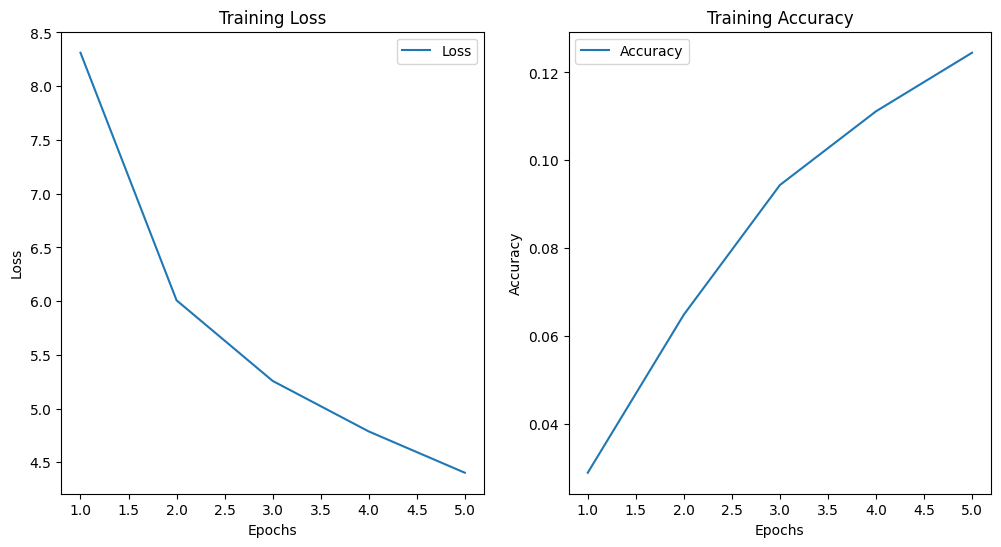

In [ ]:
def plot_training_curve(loss_history, accuracy_history):
    epochs = range(1, len(loss_history) + 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_history, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_history, label='Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_curve(loss_history, accuracy_history)

# **Evaluation**

In [ ]:

def generate_response_transformer(input_text, max_length=30, temperature=0.7):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    decoder_seq = np.zeros((1, max_len))
    decoder_seq[0, 0] = start_token_idx
    output_text = ""
    for i in range(1, max_length):
        predictions = transformer([input_seq, decoder_seq[:, :i]], training=False)
        predictions = predictions[:, i-1, :]
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[0, 0].numpy()
        if predicted_id == end_token_idx or len(output_text.split()) >= max_length-1:
            break
        predicted_word = index_word.get(predicted_id, "")
        if predicted_word:
            output_text += predicted_word + " "
        decoder_seq[0, i] = predicted_id
    return output_text.strip()

refs, hyps = [], []
print("\nGenerating example predictions:")
test_indices = np.random.randint(0, len(questions1), 3)
for i in test_indices:
    print('-')
    print('Input:', questions1[i])
    print('Actual:', questions2[i])
    pred = generate_response_transformer(questions1[i])
    print('Predicted:', pred)
    refs.append([questions2[i]])
    hyps.append(pred)

for i in range(min(10, len(questions1))):
    q1 = questions1[i]
    q2 = questions2[i]
    hyp = generate_response_transformer(q1)
    refs.append([q2])
    hyps.append(hyp)
    print(f"\nQ1: {q1}")
    print(f"Original Q2: {q2}")
    print(f"Generated  : {hyp}")

bleu_scores = [
    sentence_bleu([word_tokenize(ref[0].lower())], word_tokenize(hyp.lower()))
    for ref, hyp in zip(refs, hyps)
]
print(f"\nAverage BLEU: {np.mean(bleu_scores):.4f}")

rouge = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
rouge_scores = [rouge.score(ref[0], hyp) for ref, hyp in zip(refs, hyps)]
avg_rouge1 = np.mean([s['rouge1'].fmeasure for s in rouge_scores])
print(f"Average ROUGE-1 F1: {avg_rouge1:.4f}")

meteor_scores = [
    meteor_score([word_tokenize(ref[0].lower())], word_tokenize(hyp.lower()))
    for ref, hyp in zip(refs, hyps)
]
print(f"Average METEOR: {np.mean(meteor_scores):.4f}")

start_infer = time.time()
_ = generate_response_transformer("What is your name?")
end_infer = time.time()
print(f"\nInference Time: {end_infer - start_infer:.4f} seconds")


Generating example predictions:
-
Input: How do covert narcissists abuse their partners?
Actual: What are some tips for negotiating with a covert narcissist?
Predicted: what are some ways to deal on snapchat end out of lymph spin end off end end end and how do i don't know end end in our mind
-
Input: What is the significance of the size of the address bus and the data bus in the processors? How is the type of the processors is defined like 8-bit, 16-bit processors, etc
Actual: What is a 128-bit processor?
Predicted: of the bio and aspire and eponine without a website end in my way end and other than the internet end of them end in this end of consent
-
Input: People needs rikshaw stands. Aren't you having trouble due to them?
Actual: I want to move to IT but I don’t know programming nor do I want to do programming. Are there any other career paths?
Predicted: makes a girl ever ever been more than extraterrestrial life end or not end what should i do end and want to use end end end en

In [ ]:
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
# ... (rest of your code) ...

# Download punkt_tab
nltk.download('punkt_tab')

# ... (rest of your code) ...
bleu_scores = [
    sentence_bleu([word_tokenize(ref[0].lower())], word_tokenize(hyp.lower()))
    for ref, hyp in zip(refs, hyps)
]
# ... (rest of your code) ...

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram o

# **Attention Map Visualization**

In [ ]:
def plot_attention_weights(input_sentence, result, attention_weights):
    # Assuming attention_weights is a list of attention matrices for each head
    fig = plt.figure(figsize=(16, 8))
    input_tokens = input_sentence.split()
    output_tokens = result.split()

    # Check if attention_weights is valid and contains data
    if attention_weights is None or not isinstance(attention_weights, (list, tuple)):
        print("Attention weights are not available or in the expected format.")
        return  # or raise an exception

    for head in range(min(num_heads, len(attention_weights))):  # Ensure we don't exceed available heads
        ax = fig.add_subplot(2, num_heads // 2, head + 1)

        # Check if attention weights for this head are valid
        if isinstance(attention_weights[head], tf.Tensor):
            attention = attention_weights[head].numpy()
        else:
            print(f"Attention weights for head {head + 1} are not a TensorFlow tensor.")
            continue  # Skip to the next head

        ax.matshow(attention, cmap='viridis')
        ax.set_xticks(range(len(input_tokens)))
        ax.set_yticks(range(len(output_tokens)))
        ax.set_xticklabels(input_tokens, rotation=90)
        ax.set_yticklabels(output_tokens)
        ax.set_title(f'Head {head + 1}')
    plt.tight_layout()
    plt.show()

# Example usage:
example_input = questions1[0]
example_output = generate_response_transformer(example_input)
example_attention_weights = ... # get from your model during inference
plot_attention_weights(example_input, example_output, example_attention_weights)

Attention weights are not available or in the expected format.


<Figure size 1600x800 with 0 Axes>